#### Time series data manipulation in pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

 - pd.Timestamp
 - pd.date_range
 - pd.to_datetime

In [2]:
# Create the range of dates here
seven_days = pd.date_range(start='2017-1-1',periods=7)

# Iterate over the dates and print the number and name of the weekday
for day in seven_days:
    print(day.dayofweek, day.day_name())

6 Sunday
0 Monday
1 Tuesday
2 Wednesday
3 Thursday
4 Friday
5 Saturday


In [3]:
etfs = pd.read_csv('ml/ml_assets/etfs.csv',index_col='Dates')
etfs.index = pd.to_datetime(etfs.index)
swda = etfs[['SWDA']]

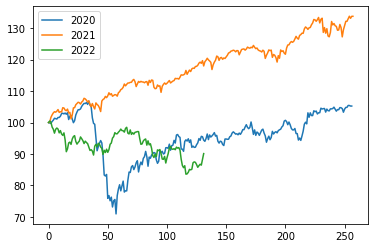

In [4]:
# Create dataframe prices here
prices = pd.DataFrame()

# Select data for each year and concatenate with prices here 
for year in ['2020', '2021','2022']:
    price_per_year = swda.loc[year, ['SWDA']].reset_index(drop=True)
    price_per_year.rename(columns={'SWDA': year}, inplace=True)
    prices = pd.concat([prices, price_per_year], axis=1)

# Plot normalized prices
prices.div(prices.loc[0]).mul(100).plot()
plt.show()

In [5]:
prices.head()

,2020,2021,2022
0,56.71,59.31,79.16
1,56.63,59.38,79.53
2,56.54,60.27,79.27
3,56.90,60.74,78.03
4,57.13,61.12,77.49


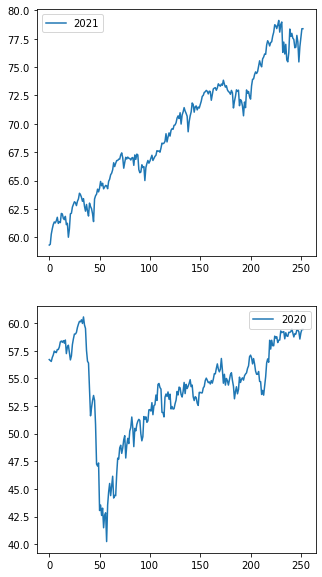

In [6]:
# Plot the time series in each dataset
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
prices.loc[:252].plot(y='2021', ax=axs[0])
prices.loc[:252].plot(y='2020', ax=axs[1])
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2019-07-30 to 2022-07-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SWDA    756 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB
None


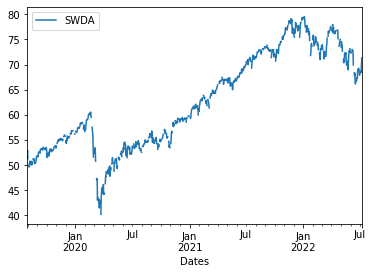

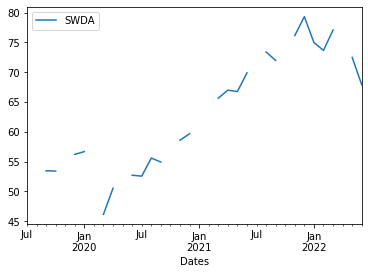

In [7]:
# Inspect data
print(swda.info())

# Set data # set the frequency to calendar daily
swda.asfreq('D').plot(subplots=True)
plt.show()

# Set frequency to monthly
swda.asfreq('M').plot(subplots=True)
plt.show()


----------
#### Random walk

 - using numpy and scipy
 - compare random walk with asset returns

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


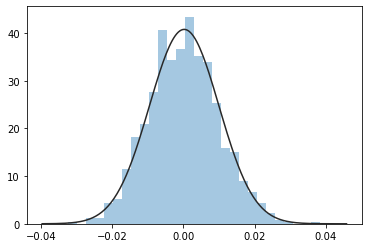

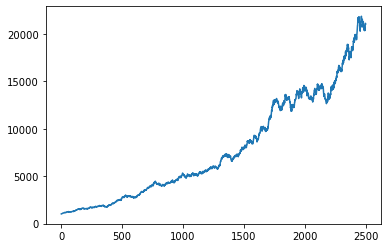

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


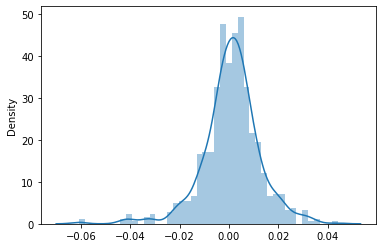

<ipython-input-8-5743f12d05a4>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swda['Random'] = random_walk.add(1)
<ipython-input-8-5743f12d05a4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swda['Random'] = swda['Random'].cumprod()


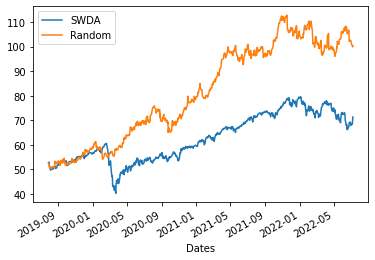

In [8]:
from numpy.random import normal, seed, choice
from scipy.stats import norm
import seaborn as sns

seed(42)

random_returns = normal(loc=0, scale=0.01, size=1000)
sns.distplot(random_returns, fit=norm, kde=False)
plt.show()

# Create random_walk
random_walk = normal(loc=.001, scale=0.01, size=2500)

# Create random_prices
random_prices = pd.Series(random_walk).add(1).cumprod()

# Plot random_prices here
random_prices.mul(1000).plot()
plt.show()


# Calculate daily_returns here
daily_returns = swda.pct_change().dropna()

# Get n_obs
n_obs = daily_returns.count()[0]

# Create random_walk
random_walk = choice(daily_returns.values.ravel(), size=n_obs)

# Convert random_walk to pd.series
random_walk = pd.Series(random_walk, index = daily_returns.index)

# Plot random_walk distribution
sns.distplot(random_walk)
plt.show()

swda['Random'] = random_walk.add(1)
swda.iloc[0,1] = swda.iloc[0,0].copy()
swda['Random'] = swda['Random'].cumprod()
swda.plot()
plt.show()

---------
#### Time series analysis

 - autocorrelation
 - white noise
 - random walk
 - AR model
 - MA model
 - ARMA model
 - Cointegration
 - ARIMA model

1. autocorrelation

 - null hypothesis is that our correlation at lag k, rk, is equal to zero at the 5% level
 - alpha = 5% means there's a 5% chance that if the true autocorrelation is 0 it falls outside the band
 - we have evidence to reject the null if values fall outside the band
 - but beware we should expect 5% of these lags to exceed these values anyway
 - further we are displaying correlated values and hence if one lag falls outside of these boundaries then proximate sequential values are more likely to do so as well
 - in practice we are looking for lags that may have some underlying reason for exceeding the 5% level
 - even if the true autocorrelations were zero at all lags, in a finite sample of returns you won't see the estimate of the autocorrelations exactly zero. In fact, the standard deviation of the sample autocorrelation is 1/N where N is the number of observations, so if N = 100, for example, the standard deviation of the ACF is 0.1, and since 95% of a normal curve is between +1.96 and -1.96 standard deviations from the mean, the 95% confidence interval is ±1.96/N. This approximation only holds when the true autocorrelations are all zero.

The autocorrelation of returns is -0.05
The approximate confidence interval is +/- 0.33

 [ 1.         -0.04499046 -0.16436617 -0.04057022  0.19759938 -0.0291837
 -0.19551148  0.34890656 -0.13510199 -0.0376401  -0.1210332   0.0475642
 -0.08562517 -0.09821601 -0.03358353 -0.12417783]


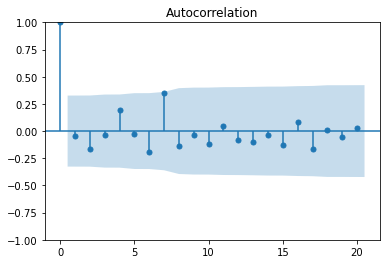

In [9]:
# Import the plot_acf module from statsmodels and sqrt from math
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt

# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf


# Resample
swda.index = pd.to_datetime(swda.index)
ret_swda = swda.SWDA.resample(rule='M').last().pct_change().dropna()

# Compute and print the autocorrelation
autocorrelation = ret_swda.autocorr()
print("The autocorrelation of returns is %4.2f" %(autocorrelation))

# Find the number of observations by taking the length of the returns DataFrame
nobs = len(ret_swda)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))


# Compute the acf array
acf_array = acf(ret_swda)
print('\n',acf_array)

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(ret_swda, alpha=0.05, lags=20)
plt.show()

# Plot the acf function without bands
# plot_acf(ret_swda, alpha=1)
# plt.show()

2. White noise

 - any process with constant mean, constant variance and zero autocorrelations at all lags (e.g. discrete white noise = process with mean equal to zero, variance equal to σ^2 and no serial correlation)
 - Gaussian white noise = process where the data has a normal distribution
 - in particular, if the values wt are drawn from a standard normal distribution (i.e. wt ∼ N (0, σ^2)), then the series is known as Gaussian white noise

The mean is 0.020 and the standard deviation is 0.049


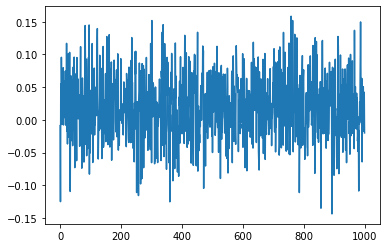

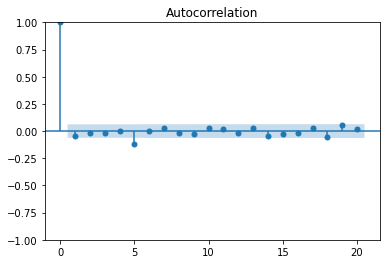

In [10]:
# Simulate white noise returns
returns = np.random.normal(loc=0.02, scale=0.05, size=1000)

# Print out the mean and standard deviation of returns
mean = np.mean(returns)
std = np.std(returns)
print("The mean is %5.3f and the standard deviation is %5.3f" %(mean,std))

# Plot returns series
plt.plot(returns)
plt.show()

# Plot autocorrelation function of white noise returns
plot_acf(returns, lags=20)
plt.show()

3. random walk

 - when the change (difference) in a process's values is a white noise, then the series is a random walk
     - Pt - Pt_1 = Et
     - if prices are in logarithmic, then the difference in log prices is actually the asset's returns
     - if stock prices follow a random walk, then stock returns are a white noise process
 - if prices are a random walk with a drift μ, the returns are still white noise but with non-zero mean (Pt - Pt_1 = μ + Et)
 - to test if a series is a random walk, we can regress current prices on lagged prices
     - Pt = a + b x Pt_1 + Et
     - if the slope coefficient is not significantly different from 1, then you cannot reject the Ho: b=1, i.e. the series may be a random walk process
     - if the slope coeff is significantly less than 1, then you can reject the null hypothesis (H1: b<1)
 - alternatively you can regress the difference in prices on the lagged prices
     - Pt - Pt_1 = a + b x Pt_1 + Et
     - then the null becomes Ho: b = 0 (Dickey - Fuller test)
     - if there are more lagged prices then it is the Augmented DF test
     - if you cannot reject the null then the process is considered to be non-stationary
     - if you can reject the null, then the process is assumed to be stationary
     - ADF test is used to determine the presence of unit root in the series, and hence helps to understand if the series is stationary or not. The null and alternate hypothesis of this test are:
         - Null Hypothesis: The series has a unit root.
         - Alternate Hypothesis: The series has no unit root.
         - If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary
     - finally, the ADF tests for "trend" stationarity
     - link https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
     
  - also check out the KPSS and the PP tests
  
  - to make a series stationary you can take the first or second difference, take the logs, take the square root, or proportional change, a classic way of transforming stock time series is the log-return of the series e.g. np.log(amazon/amazon.shift(1)).dropna()

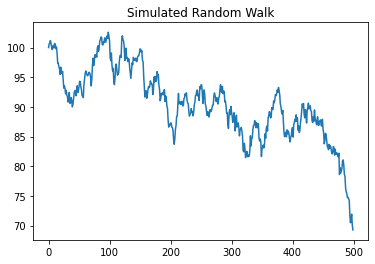

In [11]:
# Generate 500 random steps with mean=0 and standard deviation=1
steps = np.random.normal(loc=0, scale=1.0, size=500)

# Set first element to 0 so that the first price will be the starting stock price
steps[0]=0

# Simulate stock prices, P with a starting price of 100
P = 100 + np.cumsum(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk")
plt.show()

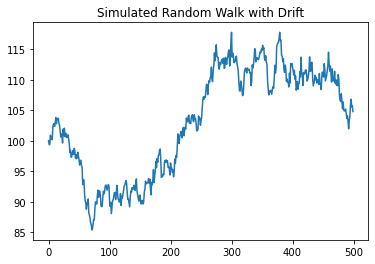

In [12]:
# Generate 500 random steps 
steps = np.random.normal(loc=0.001, scale=0.01, size=500) + 1

# Set first element to 1
steps[0]=1

# Simulate the stock price, P, by taking the cumulative product
P = 100 * np.cumprod(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk with Drift")
plt.show()

In [13]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

display(help(adfuller))

# Run the ADF test on the price series and print out the p-value
results = adfuller(swda.SWDA)
display(results)
print('The p-value of the test on prices is: ' + str(results[1]))


# Run the ADF test on the return series and print out the p-value
ret_results = adfuller(swda.SWDA.pct_change().dropna())
display(ret_results)
print('The p-value of the test on returns is: ' + str(ret_results[1]))

# The p-value is extremely small, so we can easily reject the hypothesis
# that returns are a random walk at all levels of significance.


Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag: 'int | None' = None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : {None, int}
        Maximum lag which is included in test, default value of
        12*(nobs/100)^{1/4} is used when ``None``.
    regression : {"c","ct","ctt","n"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "n" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
      

None

(-1.1152175568591574,
 0.7089653246357551,
 0,
 755,
 {'1%': -3.4390409569041207,
  '5%': -2.865375732701395,
  '10%': -2.568812543748081},
 1611.472272494829)

The p-value of the test on prices is: 0.7089653246357551


(-7.149116833523421,
 3.1750997636623505e-10,
 17,
 737,
 {'1%': -3.4392539652094154,
  '5%': -2.86546960465041,
  '10%': -2.5688625527782327},
 -4373.553860689135)

The p-value of the test on returns is: 3.1750997636623505e-10


4. AR

- Stationarity
     - issues with time series include the presence of a trend, seasonality (repeating patterns at regular intervals), cyclicality patterns (repeating patterns but no fixed period)
     - if a series is non-stationary, then it becomes difficult to model as there are many time-varying parameters to estimate

     - examples of non-stationary series are random walks, seasonal series, white noise with increasing mean

     - Strong: joint distribution of observations do not depend on time
         - a time series model, {xt}, is strictly stationary if the joint statistical distribution of the elements xt1, ..., xtn is the same as that of xt1+m, ..., xtn+m, ∀ t i,m.
         - another def = the distribution of a time series is unchanged for any arbitrary shift in time

     - Weak: mean, variance and autocorrelation are time invariant

     - non-stationary series can be transformed to stationary by taking logs or / and differences
      
     - so for a series to be stationary, it must have zero trend, constant variance (i.e. average distance of data points from the zero line isn't changing with time) and constant autocorrelation (how each value in the series is related to its neighbours isn't changing)
     
     
- The autoregressive model is simply an extension of the random walk that includes terms further back in time. The structure of the model is linear, that is the model depends linearly on the previous terms, with coefficients for each term. This is where the "regressive" comes from in "autoregressive". It is essentially a regression model where the previous terms are the predictors.
 
     - xt = α1xt−1 +...+αpxt−p +wt , where {wt} is white noise and αi ∈ R, with αp != 0 for a p-order autoregressive process.
     - in an AR(1) φ or α can be interpreted as mean reverting (if φ<1) or momentum (if φ>1) dynamics, in the former case negative values are followed by positive and vice versa, while in the latter positive values are followed by positive ones (and vice versa)
     - if the AR parameter, ϕ = + 0.9, the first-lag autocorrelation will be 0.9, the second-lag will be (0.9)^2 = 0.81, the third-lag will be (0.9)^3 = 0.729, etc. A smaller AR parameter will have a steeper decay, and for a negative AR parameter, say -0.9, the decay will flip signs, so the first-lag autocorrelation will be -0.9, the second-lag will be (−0.9)^2 = 0.81, the third-lag will be (−0.9)^3 = −0.729, etc.
     - not necessarily stationary model, depends on the parameters - need to solve the characteristic equation i.e. the model written in backward shift form and set to zero - we also need all of the roots to exceed the unity
     - mean of an AR(p) series is zero
     - auto-covariances and auto-correlations are given by recursive functions known as Yule-Walker equations
 

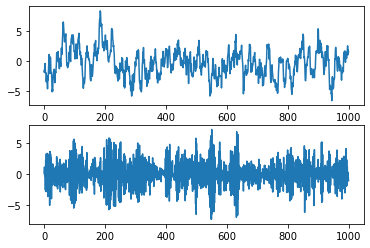

In [14]:
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess

# Plot 1: AR parameter = +0.9 (input param has the opposite sign than what's intended)
plt.subplot(2,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: AR parameter = -0.9
plt.subplot(2,1,2)
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()

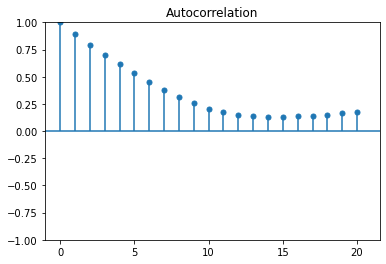

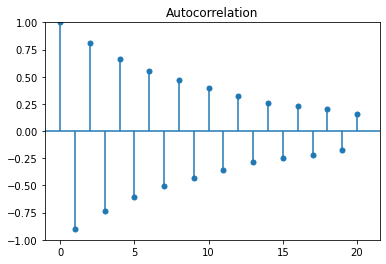

In [15]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot 1: AR parameter = +0.9
plot_acf(simulated_data_1, alpha=1, lags=20)
plt.show()

# Plot 2: AR parameter = -0.9
plot_acf(simulated_data_2, alpha=1, lags=20)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1450.874
Date:                Fri, 30 Dec 2022   AIC                           2907.747
Time:                        16:18:52   BIC                           2922.470
Sample:                             0   HQIC                          2913.343
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3819      0.311     -1.230      0.219      -0.991       0.227
ar.L1          0.8952      0.014     64.862      0.000       0.868       0.922
sigma2         1.0642      0.049     21.675      0.0

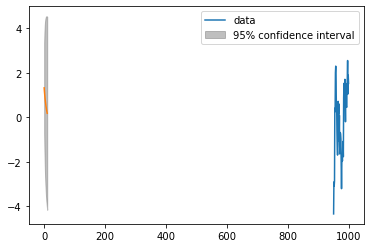

In [16]:
# Import the ARIMA and plot_predict from statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Fit an AR(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(1,0,0))
res = mod.fit()
simulated_data_1 = pd.Series(simulated_data_1)
simulated_data_1.name = 'data'

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for phi
print("When the true phi=0.9, the estimate of phi is:")
print(res.params[1])

# Plot the data and the forecast
fig, ax = plt.subplots()
simulated_data_1.loc[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)
plt.show()

In [17]:
import pandas_datareader as pdr

interest_rate_data = pdr.fred.FredReader('DGS10',start='1950-01-01').read().ffill()

In [18]:
interest_rate_data_monthly = interest_rate_data.resample('M').last()

In [19]:
interest_rate_data_monthly_shifted = interest_rate_data_monthly.shift(1).dropna()

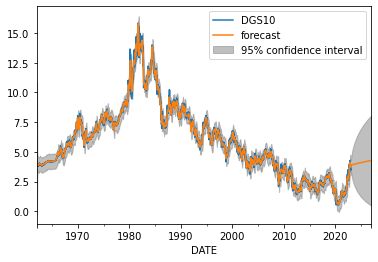

In [20]:
# Forecast interst rates using an AR(1) model
mod = ARIMA(interest_rate_data_monthly, order=(1,0,0))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
interest_rate_data.plot(ax=ax)
plot_predict(res, start=0, end='2027', ax=ax)
plt.show()

Sometimes it is difficult to distinguish between a time series that is slightly mean reverting and a time series that does not mean revert at all, like a random walk. Compare the ACF for the slightly mean-reverting interest rate series with a simulated random walk with the same number of observations.

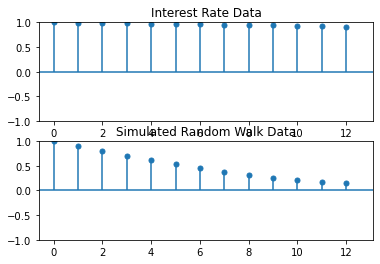

In [21]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot the interest rate series and the simulated random walk series side-by-side
fig, axes = plt.subplots(2,1)

# Plot the autocorrelation of the interest rate series in the top plot
fig = plot_acf(interest_rate_data_monthly, alpha=1, lags=12, ax=axes[0])

# Plot the autocorrelation of the simulated random walk series in the bottom plot
fig = plot_acf(simulated_data_1, alpha=1, lags=12, ax=axes[1])

# Label axes
axes[0].set_title("Interest Rate Data")
axes[1].set_title("Simulated Random Walk Data")
plt.show()

One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF). We will simulate two time series, an AR(1) and an AR(2), and calculate the sample PACF for each. We notice that for an AR(1), the PACF should have a significant lag-1 value, and roughly zeros after that. And for an AR(2), the sample PACF should have significant lag-1 and lag-2 values, and zeros after that.

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


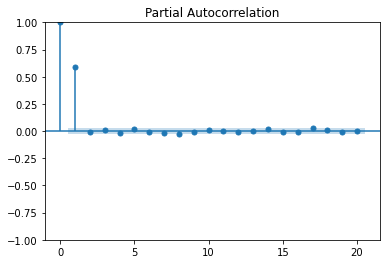

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


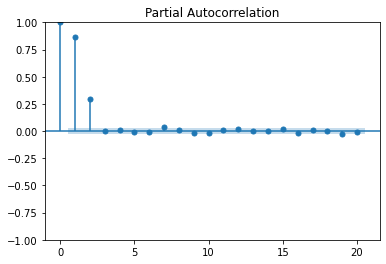

In [22]:
# Import the modules for simulating data and for plotting the PACF
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf

# Simulate AR(1) with phi=+0.6
ma = np.array([1])
ar = np.array([1, -0.6])
AR_object = ArmaProcess(ar, ma)
simulated_data_1 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(1)
plot_pacf(simulated_data_1, lags=20)
plt.show()

# Simulate AR(2) with phi1=+0.6, phi2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_2 = AR_object.generate_sample(nsample=5000)


# Plot PACF for AR(2)
plot_pacf(simulated_data_2, lags=20)
plt.show()

Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model.

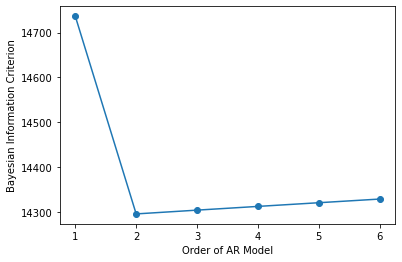

In [23]:
# Import the module for estimating an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(simulated_data_2, order=(p,0,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

5. MA models

 - a Moving Average model is similar to an Autoregressive model, except that instead of being a linear combination of past time series values, it is a linear combination of the past white noise terms
 - this means that the MA model sees such random white noise "shocks" directly at each current value of the model, in contrast to an AR(p) model, where the white noise "shocks" are only seen indirectly, via regression onto previous terms of the series
 - a key difference is that the MA model will only ever see the last q shocks for any particular MA(q) model, whereas the AR(p) model will take all prior shocks into account, albeit in a decreasingly weak manner
 - a time series model, {xt}, is a moving average model of order q, MA(q), if: xt =wt +β1wt−1 +...+βqwt−q where {wt} is white noise with E(wt) = 0 and variance σ^2
 - in a MA(1), xt = μ + wt + b1wt-1, a negative b1 parameter would be interpreted as an one-period mean reversion and a positive b1 parameter as a one-period momentum
 - one big difference you will see between out-of-sample forecasts with an MA(1) model and an AR(1) model is that the MA(1) forecasts more than one period in the future are simply the mean of the sample, in a MA(1) model all forecasts beyond the one-step ahead forecasts will be the same

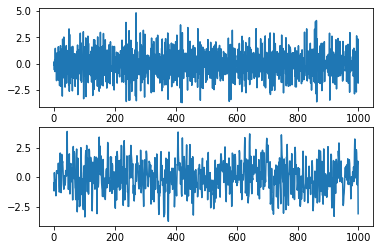

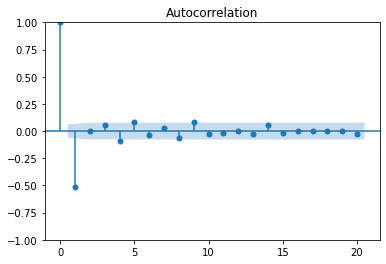

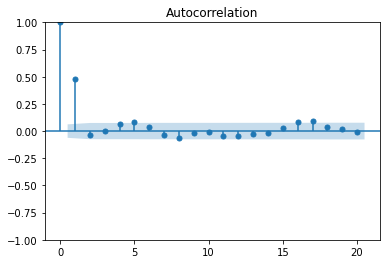

In [27]:
# Plot 1: MA parameter = -0.9
plt.subplot(2,1,1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: MA parameter = +0.9
plt.subplot(2,1,2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)

plt.show()

# Plot 1: MA parameter = -0.9
plot_acf(simulated_data_1, lags=20)
plt.show()

# Plot 2: MA parameter = 0.9
plot_acf(simulated_data_2, lags=20)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1439.654
Date:                Fri, 30 Dec 2022   AIC                           2885.308
Time:                        16:19:23   BIC                           2900.031
Sample:                             0   HQIC                          2890.904
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.003     -0.405      0.685      -0.006       0.004
ma.L1         -0.9199      0.013    -73.430      0.000      -0.944      -0.895
sigma2         1.0404      0.048     21.658      0.0

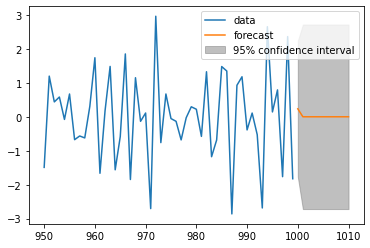

In [28]:
# Fit an MA(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(0,0,1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta is:")
print(res.params[1])

# Forecast the first MA(1) model
simulated_data_1 = pd.Series(simulated_data_1)
simulated_data_1.name = 'data'

mod = ARIMA(simulated_data_1, order=(0,0,1))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
simulated_data_1.loc[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)
plt.show()

6. ARMA
 - autoregressive moving average models ARMA = AR+MA
 - in an ARMA model the time series is regressed on the previous values and previous shock terms
 - ARMA(p,q) where p = order of AR, q = order of MA
 - xt =α1xt−1 +α2xt−2 +...+wt +β1wt−1 +β2wt−2...+βqwt−q where {wt} is white noise with E(wt) = 0 and variance σ^2
 - setting p != 0 and q = 0 we recover the AR(p) model | if p = 0 and q != 0 it is equivalent to a MA(q) model
 - one of the key features of the ARMA model is that it is parsimonious and redundant in its parameters
 - that is, an ARMA model will often require fewer parameters than an AR(p) or MA(q) model alone
 - in addition if we rewrite the equation in terms of the backward shift operator (BSO) then the θ and φ polynomials can sometimes share a common factor leading to a simpler model
 - an AR(1) model is equivalent to a MA(q) model where q=infinity, as an AR(1) model includes all error term lags
 - identifying whether a time series is stationary or non-stationary is very important, if it is stationary you can use ARMA models to predict the next values of the time series, if it is non-stationary then you cannot use ARMA models, however, you can often transform non-stationary time series to stationary ones
 
 
 
ARMAX models allow for the addition of an exogenous variable (as in linear regression) on top of AR and MA terms
e.g. using the ARIMA class

     model = ARIMA(hospital['wait_times_hrs'], order=(2,0,1), exog=hospital['nurse_count'])

You can use the arma_generate_sample() function available in your workspace to generate time series using different AR and MA coefficients.

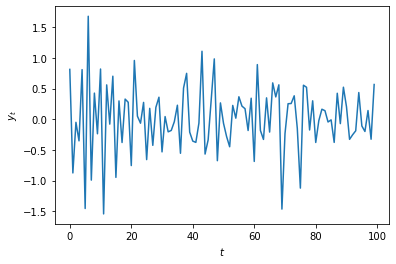

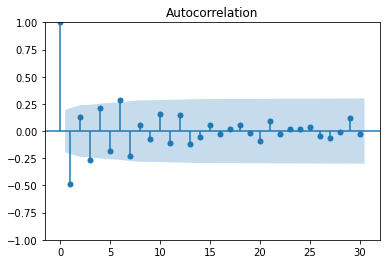

params [ 0.00929664  0.03828296 -0.78084992  0.19373589]


In [29]:
# Import data generation function and set random seed
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(1)

# Set coefficients
ar_coefs = [1]
ma_coefs = [1, -0.7]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)

plt.plot(y)
plt.ylabel(r'$y_t$')
plt.xlabel(r'$t$')
plt.show()

# Plot the ACF
plot_acf(y, lags=30)
plt.show()

# Instantiate the model
model = ARIMA(y, order=(1,0,1))

# Fit the model
results = model.fit()
print('params', results.params)

[1.0, 0.8, 0.6400000000000001, 0.5120000000000001, 0.4096000000000001, 0.3276800000000001, 0.2621440000000001, 0.20971520000000007, 0.1677721600000001, 0.13421772800000006, 0.10737418240000006, 0.08589934592000005, 0.06871947673600004, 0.054975581388800036, 0.043980465111040035, 0.03518437208883203, 0.028147497671065624, 0.022517998136852502, 0.018014398509482003, 0.014411518807585602, 0.011529215046068483, 0.009223372036854787, 0.00737869762948383, 0.005902958103587064, 0.004722366482869652, 0.0037778931862957215, 0.0030223145490365774, 0.002417851639229262, 0.0019342813113834097, 0.0015474250491067279]


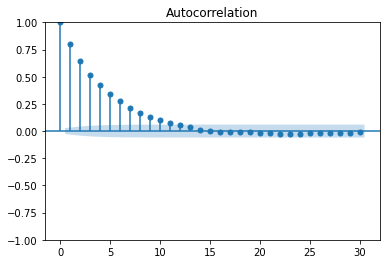

In [30]:
# Alternative way to generate an arma process

# Build a list MA parameters
ma = [.8**i for i in range(30)]
print(ma)

# Simulate the MA(30) model
ar = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=5000)

# Plot the ACF
plot_acf(simulated_data, lags=30)
plt.show()

7. Cointegration

 - a linear combination of two series that are random walks might be a stationary process, which means it may be forecastable

In [31]:
comm = pdr.fred.FredReader(['DHHNGSP','DHOILNYH'],start='1999-01-01').read().ffill().dropna()
comm.head()

,DHHNGSP,DHOILNYH
DATE,,
1999-01-04,2.10,0.346
1999-01-05,2.05,0.338
1999-01-06,2.04,0.354
1999-01-07,1.91,0.352
1999-01-08,1.90,0.360


In [32]:
NG = comm['DHHNGSP'].copy()
HO = comm['DHOILNYH'].copy()

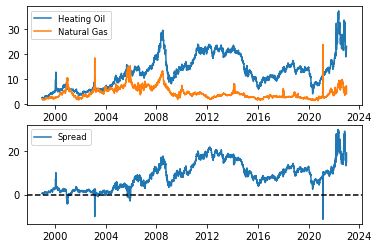

In [33]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25 *HO-NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

In [34]:
# Compute the ADF for HO and NG
result_HO = adfuller(HO)
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG)
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread - ORIGINAL: result_spread = adfuller(7.25 * HO - NG)
result_spread = adfuller(HO - NG)
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.18519914358007838
The p-value for the ADF test on NG is  0.000862173075410641
The p-value for the ADF test on the spread is  0.0012847831049422143


Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was (1,-1). In other words, we took the difference between the two series (after doing a units conversion).

You will regress the value of one cryptocurrency, bitcoin (BTC), on another cryptocurrency, ethereum (ETH). If we call the regression coefficient b, then the cointegration vector is simply (1,−b). Then perform the ADF test on BTC −b * ETH.

In [39]:
import statsmodels.api as sm

In [40]:
crypto = pdr.fred.FredReader(['CBBTCUSD','CBETHUSD'],start='2010-01-01').read().ffill().dropna()
print(crypto.head())

ETH = crypto['CBETHUSD'].copy()
BTC = crypto['CBBTCUSD'].copy()

# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC,ETH).fit()

# Compute ADF
b = result.params[1]
print('param', b)
adf_stats = adfuller(BTC - b*ETH['CBETHUSD'])
print("The p-value for the ADF test is ", adf_stats[1])

            CBBTCUSD  CBETHUSD
DATE                          
2016-05-18    455.56     13.18
2016-05-19    438.38     14.90
2016-05-20    445.65     14.17
2016-05-21    446.28     14.17
2016-05-22    442.48     14.17
param 13.745215762128876
The p-value for the ADF test is  0.007868942832149449


In [41]:
temp_NY = pd.read_csv('assets/time_series/NOAA_TAVG.csv',index_col='DATE')
temp_NY.head()

,TAVG
DATE,
1870,53.8
1871,51.3
1872,51.3
1873,50.9
1874,51.3


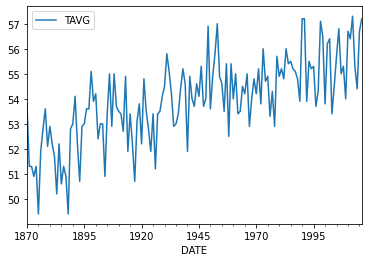

The p-value for the ADF test is  0.5832938987871124


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


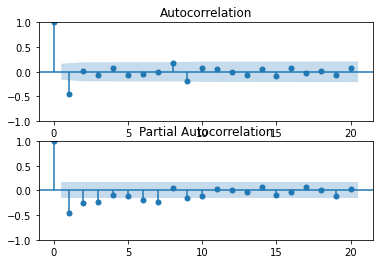

The AIC for an AR(1) is:  510.5346898733112


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWar

The AIC for an AR(2) is:  501.92741234091375
The AIC for an ARMA(1,1) is:  469.072918924161


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


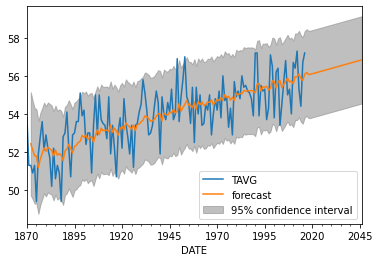

In [42]:
# --------------------------------------------------------- 1. Review
# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

# Plot average temperatures
temp_NY.plot()
plt.show()

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

# --------------------------------------------------------- 2. Transform
# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

# --------------------------------------------------------- 3. Model and evaluate
# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1,0,0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2,0,0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1,0,1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

# --------------------------------------------------------- 4. Predict

# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, trend='t', order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
temp_NY.plot(ax=ax)
plot_predict(res, start='1872', end='2046', ax=ax)
plt.show()

# According to the model, the temperature is expected to
# be about 0.6 degrees higher in 30 years (almost entirely due to the trend),
# but the 95% confidence interval around that is over 5 degrees.

8. ARIMA

- ARIMA models are used because they can reduce a non-stationary series to a stationary series using a sequence of differencing steps (you want to make sure our data is stationary but don't want to over difference it either)
     - ARIMA essentially performs differencing repeatedly d times in order to reduce a non-stationary series to a stationary one

     - Integrated Series of order d. A time series {xt} is integrated of order d, I(d), if:
         - ∇dxt = wt that is, if we difference the series d times we receive a discrete white noise series

     - Autoregressive Integrated Moving Average Model of order p, d, q: a time series {xt} is an autoregressive integrated moving average model of order p, d, q, ARIMA(p,d,q), if ∇dxt is an autoregressive moving average model of order p,q, ARMA(p,q), that is, if the series {xt} is differenced d times, and it then follows an ARMA(p,q) process, then it is an ARIMA(p,d,q) series
     
     
- In order to handle other forms of non-stationarity beyond stochastic trends additional models can be used:    
     - Seasonality effects such as those that occur in commodity prices can be tackled with the Seasonal ARIMA model (SARIMA)
     - Conditional heteroskedastic effects such as volatility clustering in equities indexes can be tackled with ARCH and GARCH


9. Selecting a model

 - use ACF or PACF to find which model (its order) to fit and use for predictions
     - the autocorrelation function, at lag N, is the correlation between a time series and the same time series offset by N-steps
     - if the ACF values are small and lie in the bands (blue shade region in the ACF plot) they are not statistically significant
     - if they are large and lie beyond the bands then the model's order need to be calibrated
     - the null hypothesis is our correlation at lag k, rk, is equal to zero at the 5% level
     - the PACF is the correlation between a time series and a lagged version of itself minus the effect of correlation at smaller lags | link: https://en.wikipedia.org/wiki/Partial_autocorrelation_function
     - so it is the correlation associated with just a particular lag
     
     <img src="assets/time_series/ar.png" style="height: 200px;"/>
     <img src="assets/time_series/ma.png" style="height: 200px;"/>
     <img src="assets/time_series/arma.png" style="height: 200px;"/>

     - if the ACF values are high and tail off slowly it is a sign that the series is non-stationary
     - if the ACF value at lag minus 1 is negative and significant it is a sign that we have taken differences too many times
     
 - use AIC and BIC to evaluate the model
     - for both AIC and BIX lower scores indicate better model predictions
     - both information criteria penalize models with lots of parameters, that is if the model order is too high compared to the data the AIC/BIC will be higher, hence stopping overfitting to the data
     - but the BIC penalizes additional model orders more than the AIC, so the BIC sometimes suggests a simpler model
     - so if the goal is to find a good predictive model we should use the AIC, but if the goal is to find a good explanatory model then we might be better off counting more on BIC
  
 - run diagnostics
     - use the model residuals to check whether they resemble a white noise process (otherwise there is missing information the model hasn't captured)
     - Ljung-Box: Null = There are no correlations in the residual, Prob(Q) -> reject the Ho if Prob <5%
     - Jarque-Bera:	Null = The residuals are normally distributed, Prob(JB) -> reject the Ho if Prob <5%
     
     - Standardized residual: There are no obvious patterns in the residuals
     - Histogram plus kde estimate:	The KDE curve should be very similar to the normal distribution
     - Normal Q-Q:	Most of the data points should lie on the straight line
     - Correlogram:	95% of correlations for lag greater than zero should not be significant
  
  
  
  - Box-Jenkins method
      - link: https://en.wikipedia.org/wiki/Box–Jenkins_method
      - a series of steps to analyse time series via Identification - Estimation - Model diagnostics
      - identification tools:
          - plot time series
          - run ADF test
          - use transformations or differencing to make series stationary
          - plot ACF/PACF
          - use df.plot(), adfuller(), df.diff(), df.log(), np.sqrt(), plot_acf(), plot_pacf()
      - estimation:
          - use data to train the model coefficients
          - select models based on AIC and BIC
          - use model.fit() and results.aic, results.bic
      - model diagnostics:
          - are the residuals serially uncorrelated
          - are the residuals normally distributed
          - use results.plot_diagnostics() and results.summary()
      - if the model looks ok, you can move ahead with results.get_forecast()

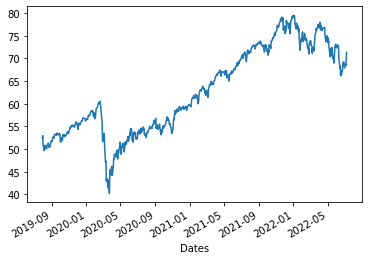

(-1.1152175568591574,
 0.7089653246357551,
 0,
 755,
 {'1%': -3.4390409569041207,
  '5%': -2.865375732701395,
  '10%': -2.568812543748081},
 1611.472272494829)

(-7.149116833523421,
 3.1750997636623505e-10,
 17,
 737,
 {'1%': -3.4392539652094154,
  '5%': -2.86546960465041,
  '10%': -2.5688625527782327},
 -4373.553860689135)

Rejecting the ADF Ho of unit root based on p-value 0.0


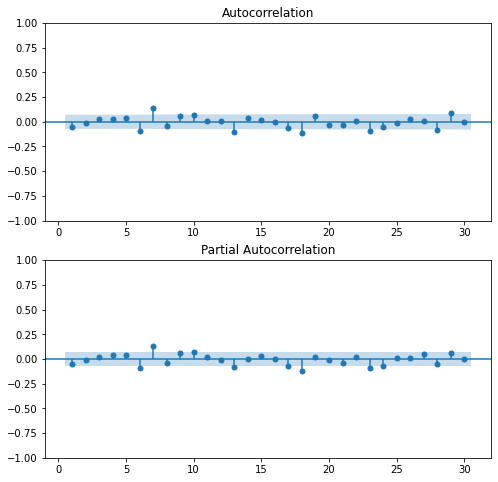

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmod

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_mode

,Order,AIC,BIC
2,"[0, 1]",-4476.434197,-4462.554044
5,"[1, 0]",-4476.391735,-4462.511582
1,"[0, 0]",-4476.108336,-4466.8549
9,"[2, 0]",-4474.516585,-4456.009714
6,"[1, 1]",-4474.449723,-4455.942852


,Order,AIC,BIC
1,"[0, 0]",-4476.108336,-4466.8549
2,"[0, 1]",-4476.434197,-4462.554044
5,"[1, 0]",-4476.391735,-4462.511582
9,"[2, 0]",-4474.516585,-4456.009714
6,"[1, 1]",-4474.449723,-4455.942852


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                   SWDA   No. Observations:                  755
Model:                 ARIMA(0, 0, 1)   Log Likelihood                2241.217
Date:                Fri, 30 Dec 2022   AIC                          -4476.434
Time:                        16:36:08   BIC                          -4462.554
Sample:                             0   HQIC                         -4471.088
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.017      0.309      -0.000       0.001
ma.L1         -0.0539      0.021     -2.571      0.010      -0.095      -0.013
sigma2         0.0002   3.64e-06     42.458      0.0

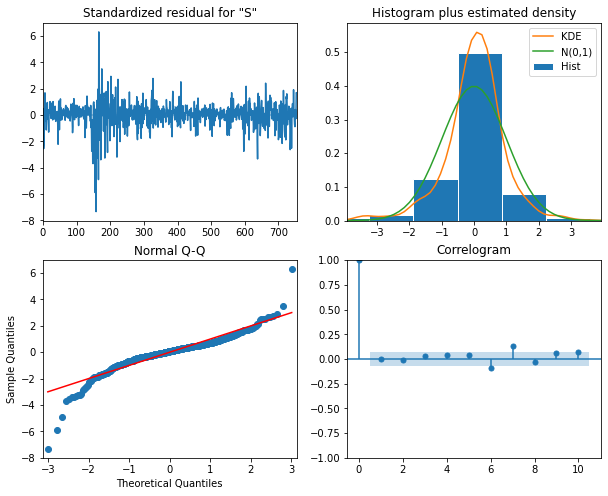

In [90]:
# ---------------------------------------------------------------------------- 1. identification
# Plot series -> non stationary ts (as you're plotting the price)
swda.SWDA.plot()
plt.show()
# Run ADF -> cannot reject the null that there is a unit root
adf_price = adfuller(swda.SWDA)


# take differences (well pct)
pct_swda = swda.SWDA.pct_change().dropna()
adf_returns = adfuller(pct_swda)
display(adf_price, adf_returns)
print('Rejecting the ADF Ho of unit root based on p-value', round(adf_returns[1],3))

# plot ACF,PCF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(pct_swda, lags=30, zero=False, ax=ax1)
plot_pacf(pct_swda, lags=30, zero=False, ax=ax2, method='ywm')
plt.show()


# train multiple model to evaluate based on AIC, BIC
results_comb = pd.DataFrame(columns=['Order','AIC','BIC'],index = list(range(1,21)))
ind = 1
for p in range(4):
    for q in range(4):
        try:
            # create and fit ARMA(p,q) model | alternative model = ARIMA(swda.SWDA, order=(p,1,q))
            model = ARIMA(pct_swda, order=(p,0,q))
            results = model.fit()
            results_comb.loc[ind,['Order','AIC','BIC']] = [[p,q], results.aic, results.bic]
            
        except:
            print('N/A for ', p, q)
        
        ind += 1
        
results_comb = results_comb.dropna()
display(results_comb.sort_values(by=['AIC']).head(5),
        results_comb.sort_values(by=['BIC']).head(5))


# ---------------------------------------------------------------------------- 2. estimation
# Select and fit model
model = ARIMA(pct_swda, order=(0,0,1))
results_swda = model.fit()
print(results_swda.summary())

# ---------------------------------------------------------------------------- 3. diagnostics
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results_swda.resid))

# Print mean absolute error
print(mae)

# Plot diagnostics
results_swda.plot_diagnostics(figsize=(10,8))
plt.show()

Then do forecasting (if the model is good, which the above is not)

In [92]:
# ---------------------------------------------------------------------------- 4. Day ahead prediction


# Generate predictions
one_step_forecast = results_swda.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = pd.Series(one_step_forecast.predicted_mean)

# Get confidence intervals of predictions
confidence_intervals = pd.DataFrame(one_step_forecast.conf_int(), columns=['lower close','upper close'])

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower close']
upper_limits = confidence_intervals.loc[:,'upper close']

# Print best estimate predictions
print(mean_forecast)

# plot the amazon data
plt.plot(pct_swda.index, pct_swda, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend()
plt.show()

Dates
2022-05-27   -0.000335
2022-05-30   -0.000597
2022-05-31    0.000106
2022-06-01    0.000979
2022-06-02    0.000584
2022-06-03    0.000407
2022-06-06    0.000687
2022-06-07    0.000032
2022-06-08    0.000666
2022-06-09    0.000419
2022-06-10    0.000975
2022-06-13    0.002241
2022-06-14    0.001802
2022-06-15    0.001026
2022-06-16    0.000137
2022-06-17    0.002167
2022-06-20    0.000531
2022-06-21    0.000183
2022-06-22   -0.000101
2022-06-23    0.000570
2022-06-24    0.000390
2022-06-27   -0.000803
2022-06-28    0.000257
2022-06-29    0.000587
2022-06-30    0.000947
2022-07-01    0.001073
2022-07-04    0.000204
2022-07-05    0.000214
2022-07-06    0.000664
2022-07-07   -0.000658
Name: predicted_mean, dtype: float64


Dates
2022-05-27   -0.000335
2022-05-30    0.000479
2022-05-31    0.000479
2022-06-01    0.000479
2022-06-02    0.000479
2022-06-03    0.000479
2022-06-06    0.000479
2022-06-07    0.000479
2022-06-08    0.000479
2022-06-09    0.000479
2022-06-10    0.000479
2022-06-13    0.000479
2022-06-14    0.000479
2022-06-15    0.000479
2022-06-16    0.000479
2022-06-17    0.000479
2022-06-20    0.000479
2022-06-21    0.000479
2022-06-22    0.000479
2022-06-23    0.000479
2022-06-24    0.000479
2022-06-27    0.000479
2022-06-28    0.000479
2022-06-29    0.000479
2022-06-30    0.000479
2022-07-01    0.000479
2022-07-04    0.000479
2022-07-05    0.000479
2022-07-06    0.000479
2022-07-07    0.000479
Name: predicted_mean, dtype: float64


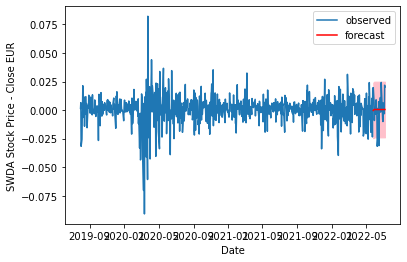

In [97]:
# ----------------------------------------------------- 5. Dynamic predictions (n-periods ahead forecasts)

# Generate predictions
dynamic_forecast = results_swda.get_prediction(start=-30, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower SWDA']
upper_limits = confidence_intervals.loc[:,'upper SWDA']

# Print best estimate predictions
print(mean_forecast)

# plot dynamic pred
# plot the amazon data
plt.plot(pct_swda.index, pct_swda, label='observed')


# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('SWDA Stock Price - Close EUR')
plt.legend()
plt.show()


In [99]:
# Repeat the same exercise but with an ARIMA model to forecaste the absolute values

# Create ARIMA(2,1,2) model
arima = ARIMA(swda.SWDA, order=(0,1,1))

# Fit ARIMA model
arima_results = arima.fit()

# Make ARIMA forecast of next 10 values
arima_value_forecast = arima_results.get_forecast(steps=10).predicted_mean

# Print forecast
print(arima_value_forecast)

756    71.286604
757    71.286604
758    71.286604
759    71.286604
760    71.286604
761    71.286604
762    71.286604
763    71.286604
764    71.286604
765    71.286604
Name: predicted_mean, dtype: float64


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

10. Seasonal time series & SARIMA

    - time series = trend + seasonal + residuals
    - you can think of a time series as being composed of trend, seasonal and residual components
    - this can be a good way to think about the data when you go about modeling it, if you know the period of the time series you can decompose it into these components
    - seasonality is not always visible with the eye, an ACF plot helps in this case
    - in practice it's like training two ARIMA models 
         <img src="assets/time_series/sarima.png" style="height: 170px;"/>
    - use the ACF and PACF to test this data for seasonality, you can see from the plot whether the time series isn't stationary (if so you should probably detrend it)
    - detrending a TS by subtracting the moving average

    - checkout this guide for more https://towardsdatascience.com/end-to-end-time-series-analysis-and-forecasting-a-trio-of-sarimax-lstm-and-prophet-part-1-306367e57db8

In [ ]:
# # Import seasonal decompose
# from statsmodels.tsa.seasonal import seasonal_decompose

# # Perform additive decomposition
# decomp = seasonal_decompose(milk_production['pounds_per_cow'], 
#                             period=12)

# # Plot decomposition
# decomp.plot()
# plt.show()

# # Create figure and subplot
# fig, ax1 = plt.subplots()

# # Plot the ACF on ax1
# plot_acf(water['water_consumers'], lags=25, zero=False,  ax=ax1)

# # Show figure
# plt.show()

# # Subtract the rolling mean
# water_2 = water - water.rolling(15).mean()

# # Drop the NaN values
# water_2 = water_2.dropna()

# # Create figure and subplots
# fig, ax1 = plt.subplots()

# # Plot the ACF
# plot_acf(water_2['water_consumers'], lags=25, zero=False, ax=ax1)

# # Show figure
# plt.show()

In [ ]:
# # Import the SARIMAX class
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Create a SARIMA model
# model = SARIMAX(df3, order=(1,1,0), seasonal_order=(0,1,1,12))

# # Fit the model
# results = model.fit()

# # Print the results summary
# print(results.summary())


# # Take the first and seasonal differences and drop NaNs
# aus_employment_diff = aus_employment.diff().diff(12).dropna()


# # Create ARIMA mean forecast
# arima_pred = arima_results.get_forecast(steps=25)
# arima_mean = arima_pred.predicted_mean

# # Create SARIMA mean forecast
# sarima_pred = sarima_results.get_forecast(steps=25)
# sarima_mean = sarima_pred.predicted_mean

# # Plot mean ARIMA and SARIMA predictions and observed
# plt.plot(dates, sarima_mean, label='SARIMA')
# plt.plot(dates, arima_mean, label='ARIMA')
# plt.plot(wisconsin_test, label='observed')
# plt.legend()
# plt.show()

# # You can see that the SARIMA model has forecast the upward trend and the seasonal 
# # cycle, whilst the ARIMA model has only forecast the upward trend with an added
# # wiggle. This makes the SARIMA forecast much closer to the truth for this seasonal data!


# # Import model class
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Create model object
# model = SARIMAX(co2, 
#                 order=(1, 1, 1),  
#                 seasonal_order=(0, 1, 1, 12), 
# )
# # Fit model
# results = model.fit()

# # Plot common diagnostics
# results.plot_diagnostics()
# plt.show()

# # Create forecast object
# forecast_object = results.get_forecast(steps=136)

# # Extract prediction mean
# mean = forecast_object.predicted_mean

# # Extract the confidence intervals
# conf_int = forecast_object.conf_int()

# # Extract the forecast dates
# dates = mean.index

# plt.figure()

# # Plot past CO2 levels
# plt.plot(co2.index, co2, label='past')

# # Plot the prediction means as line
# plt.plot(dates, mean, label='predicted')

# # Shade between the confidence intervals
# plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)

# # Plot legend and show figure
# plt.legend()
# plt.show()


# # Print last predicted mean
# print(mean.iloc[-1])

# # Print last confidence interval
# print(conf_int.iloc[-1])



### Save data

 - https://joblib.readthedocs.io/en/latest/

In [103]:
import joblib


# Set model name
filename = "test_model.pkl"


# Pickle it
joblib.dump(test_model, filename)


# Load the model back in
loaded_model = joblib.load(filename)


# Update the model
loaded_model.update(df_new)

### Import data

In [1]:
from glob import glob

In [7]:
glob('*.ipynb')

['02_garch_modeling.ipynb',
 '14_big_data_fundamentals_with_pyspark.ipynb',
 '25_scala.ipynb',
 '18_developing_packages.ipynb',
 '20_cleaning_data.ipynb',
 '26_sql.ipynb',
 '21_data_joins_with_pandas.ipynb',
 '11_airflow.ipynb',
 '12_bash.ipynb',
 '26_command_line_automation.ipynb',
 '22_unit_testing.ipynb',
 '01_credit_risk_modeling.ipynb',
 '17_regex.ipynb',
 '13_intro_to_pyspark.ipynb',
 '27_postgresql_fundamentals.ipynb',
 '03_quant_risk_management.ipynb',
 '05_efficient_python.ipynb',
 '07_spark_notes.ipynb',
 '04_databases_design.ipynb',
 '16_importing_and_scraping_data.ipynb',
 '24_time_series_analysis.ipynb',
 '19_dates_and_time.ipynb',
 '23_git.ipynb',
 '15_data_cleaning_with_spark.ipynb',
 '06_object_oriented_prog_python.ipynb',
 '08_databases_intro_and_sqlalchemy.ipynb',
 '10_mongodb.ipynb',
 '09_aws_boto.ipynb']

### Numpy
 - np.column_stack
 - np.hstack
 - np.vstack
 - np.partial
 - np.linspace
 - np.interpolate

In [ ]:
# # Import partial from functools
# from functools import partial
# percentiles = [1, 10, 25, 50, 75, 90, 99]

# # Use a list comprehension to create a partial function for each quantile
# percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# # Calculate each of these quantiles on the data using a rolling window
# prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
# features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# # Plot a subset of the result
# ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
# ax.legend(percentiles, loc=(1.01, .5))
# plt.show()

### Fourier transforms

 - TS = quickly-changing + slowely-changing components
 - Fourier transforms = summarises TS into collections of fast and slow-moving waves
 - FFT tells us how these waves can be combined in different amounts to create the original TS
 
    <img src="assets/time_series/fft.png" style="height: 270px;"/>

 - A spectrogram is a collection of windowed FFT over time
     - Choose a window size and shape
     - At a timepoint calculate FFT for that window
     - Slide the window over by one
     - Aggregate the results
     - This is called a Short-time fourier transform (STFT)
 
 
 - Spectral engineering is one of the most common techniques in machine learning for time series data. The first step in this process is to calculate a spectrogram of sound. This describes what spectral content (e.g., low and high pitches) are present in the sound over time. 

In [1]:
# # Import the stft function
# from librosa.core import stft

# # Prepare the STFT
# HOP_LENGTH = 2**4
# spec = stft(audio, hop_length=HOP_LENGTH, n_fft=2**7)

# from librosa.core import amplitude_to_db
# from librosa.display import specshow

# # Convert into decibels
# spec_db = amplitude_to_db(spec)

# # Compare the raw audio to the spectrogram of the audio
# fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# axs[0].plot(time, audio)
# specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH, ax=axs[1])
# plt.show()

# import librosa as lr

# # Calculate the spectral centroid and bandwidth for the spectrogram
# bandwidths = lr.feature.spectral_bandwidth(S=spec)[0]
# centroids = lr.feature.spectral_centroid(S=spec)[0]

# spec_db = amplitude_to_db(spec)

# # Display these features on top of the spectrogram
# fig, ax = plt.subplots(figsize=(10, 5))
# specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH, ax=ax)
# ax.plot(times_spec, centroids)
# ax.fill_between(times_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
# ax.set(ylim=[None, 6000])
# plt.show()

### Cross-validation for time-series data

In [ ]:
from sklearn.model_selection import KFold
    cv = KFold(n_splits=5)
    for tr, tt in cv.split(X, y):
        ''
        
fig, axs = plt.subplots(2, 1)

# Plot the indices chosen for validation on each loop
axs[0].scatter(tt, [0] * len(tt), marker='_', s=2, lw=40)
axs[0].set(ylim=[-.1, .1], title='Test set indices (color=CV loop)',
           xlabel='Index of raw data')

# Plot the model predictions on each iteration
axs[1].plot(model.predict(X[tt]))
axs[1].set(title='Test set predictions on each CV loop',
           xlabel='Prediction index')

<img src="assets/time_series/cv.png" style="height: 270px;"/>

### Shuffling TS data

 - appropriate only if data is iid, but most time series data is not
 - you should not be using shuffling when making predictions with time series data
 
 Shuffled data - no longer looks as a time series because the temporal structure of the data has been destroyed
 
 
 <img src="assets/time_series/shuffled.png" style="height: 270px;"/>

### CV iterator

 - more appropriate for time series data as it always uses data from the past to predict the future
 - more closely approximates the real-world data collection and analysis process

In [ ]:
# Import and initialize the cross-validation iterator
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=10)
fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)],
                    marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)],
                    marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior',
           xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

 
 <img src="assets/time_series/cv-ts.png" style="height: 270px;"/>